In [136]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from imageio.v3 import imread
import matplotlib.pyplot as plt

In [137]:
train = pd.read_csv('airbus-ship-detection/train_ship_segmentations_v2.csv')
train_id = train['ImageId']
test = pd.read_csv("airbus-ship-detection/sample_submission_v2.csv", index_col=0)

train

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,NaN
231719,ffff2aa57.jpg,NaN
231720,ffff6e525.jpg,NaN
231721,ffffc50b4.jpg,NaN


In [138]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

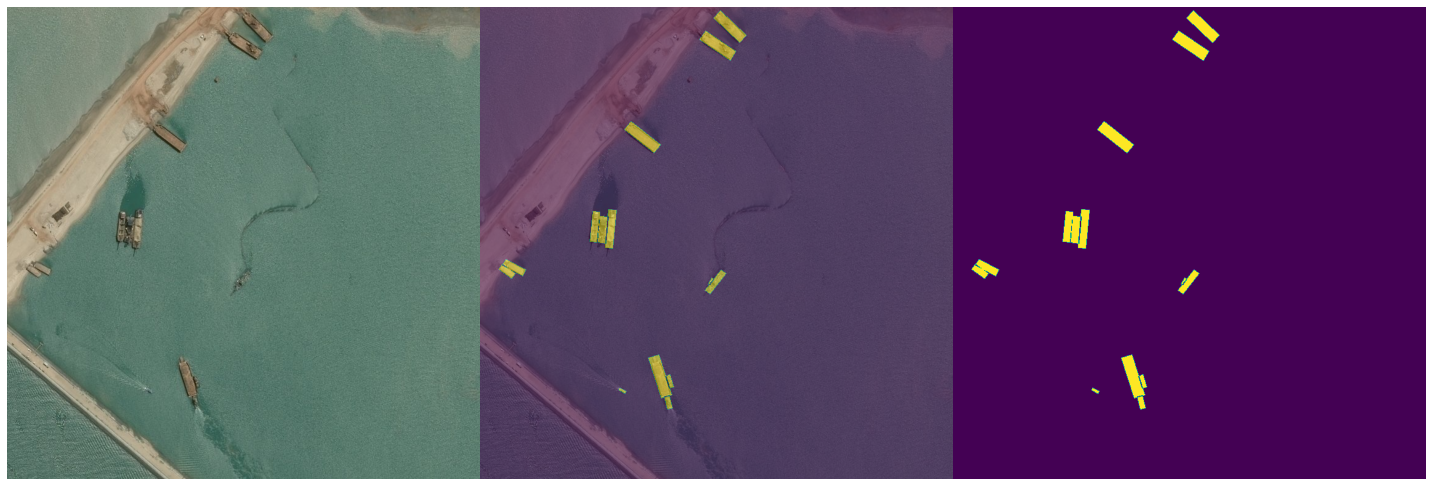

In [139]:
example_id = '0a1a7f395.jpg'
img = imread('airbus-ship-detection/train_v2/' + example_id)
img_mask = train.loc[train_id == example_id, 'EncodedPixels'].tolist()

full_mask = np.zeros((768, 768))
for mask in img_mask:
    if not mask != mask:
        full_mask += rle_decode(mask, (768, 768))

fig, axs = plt.subplots(1, 3, figsize=(20, 40))
[ax.set_axis_off() for ax in axs.ravel()]
axs[0].imshow(img)
axs[1].imshow(img)
axs[1].imshow(full_mask, alpha=0.5)
axs[2].imshow(full_mask)
plt.tight_layout(h_pad=0.1, w_pad=0.1)

plt.show()

In [140]:
train_wd = train.drop_duplicates(subset ='ImageId', keep ='first')
print(f'Number of unique images: {train_wd.shape[0]}')
print(f'Number of images with at least 1 ship: {train_wd["EncodedPixels"].nunique()}')
print(f'Number of images without ships: {train_wd.shape[0] - train_wd["EncodedPixels"].nunique()}')

Number of unique images: 192556
Number of images with at least 1 ship: 42556
Number of images without ships: 150000


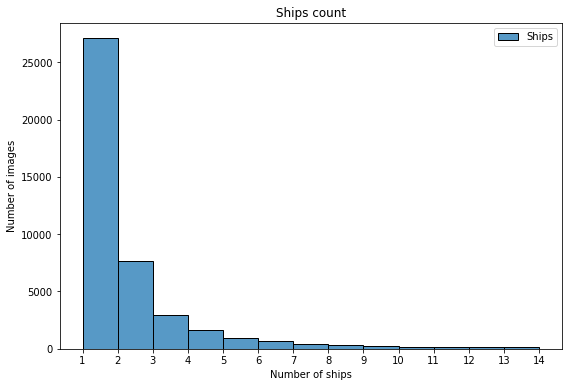

In [141]:
ships = train.dropna().groupby('ImageId').size().reset_index(name='Ships')
plt.figure(figsize=(9, 6))

sns.histplot(data=ships, bins=np.arange(1, ships['Ships'].max()))
plt.xticks(range(1, 15))
plt.title("Ships count")
plt.xlabel("Number of ships")
plt.ylabel("Number of images")

plt.show()

In [142]:
ships['Ships'].value_counts(sort=False)

1     27104
2      7674
3      2954
4      1622
5       925
6       657
7       406
8       318
9       243
10      168
11      144
12      124
13       75
14       76
15       66
Name: Ships, dtype: int64

In [143]:
train['Ships'] = train['EncodedPixels'].map(lambda x: 0 if x != x else 1)
train_new = train.groupby('ImageId').agg({'Ships': 'sum'}).reset_index()
train.drop(['Ships'], axis=1, inplace=True)
train_new['HasShip'] = train_new['Ships'].map(lambda x: 1 if x > 0 else 0)
# unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
train_new['ImageSize'] = train_new['ImageId'].map(lambda img_id: os.stat(os.path.join('airbus-ship-detection/train_v2',  img_id)).st_size/1024)
train_new = train_new[train_new['ImageSize'] > 50]

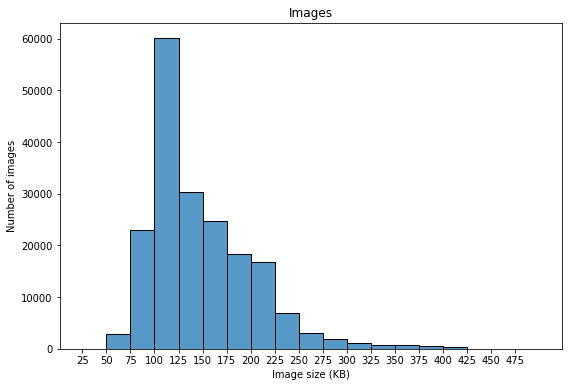

In [144]:
plt.figure(figsize=(9, 6))
sns.histplot(data=train_new['ImageSize'], bins=np.arange(25, train_new['ImageSize'].max(), 25))
plt.xticks(range(25, 500, 25))
plt.title("Images")
plt.xlabel("Image size (KB)")
plt.ylabel("Number of images")

plt.show()

In [145]:
train_new.drop(['ImageSize'], axis=1, inplace=True)
train_new

,ImageId,Ships,HasShip
0,00003e153.jpg,0,0
1,0001124c7.jpg,0,0
2,000155de5.jpg,1,1
3,000194a2d.jpg,5,1
4,0001b1832.jpg,0,0
...,...,...,...
192551,fffedbb6b.jpg,0,0
192552,ffff2aa57.jpg,0,0
192553,ffff6e525.jpg,0,0
192554,ffffc50b4.jpg,0,0


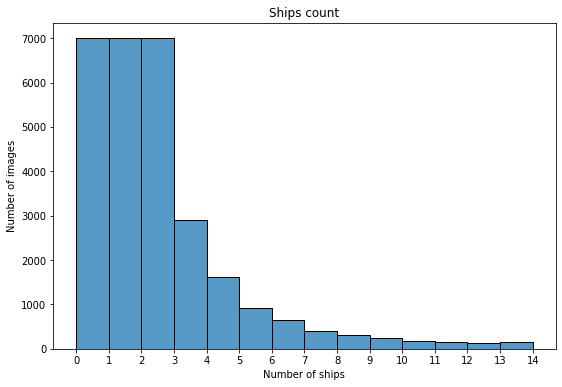

In [154]:
sample_size = 7000
train_new_balanced = train_new.groupby('Ships').apply(lambda x: x.sample(sample_size) if len(x) > sample_size else x)

plt.figure(figsize=(9, 6))

sns.histplot(data=train_new_balanced['Ships'], bins=np.arange(train_new_balanced['Ships'].max()))
plt.xticks(range(15))
plt.title("Ships count")
plt.xlabel("Number of ships")
plt.ylabel("Number of images")

plt.show()

In [155]:
train_new_balanced['Ships'].value_counts()

0     7000
1     7000
2     7000
3     2908
4     1608
5      917
6      652
7      405
8      314
9      241
10     168
11     144
12     122
14      76
13      75
15      66
Name: Ships, dtype: int64

In [156]:
print(train_new_balanced.shape)
train_new_balanced.sample(10)

(28696, 3)


ImageId  Ships  HasShip
Ships                                      
4     65744   5787c6361.jpg      4        1
3     163533  d97fd9364.jpg      3        1
2     149823  c746f775e.jpg      2        1
11    92997   7b992de0c.jpg     11        1
1     79357   69649f79d.jpg      1        1
3     86993   7386a82c3.jpg      3        1
2     100343  85700d798.jpg      2        1
      116758  9b2c34723.jpg      2        1
3     142558  bd87062b2.jpg      3        1
5     153921  cca8f5286.jpg      5        1

In [157]:
train_new_balanced.to_csv('train_data.csv', index=False)